##**Importar modelo, dataset de test y vocabulario**

In [45]:
from google.colab import drive
import tensorflow as tf
import tensorflow_text as tf_text
import numpy as np
import os

# Montar Drive
drive.mount('/content/gdrive')

# Ruta base
base_dir = "/content/gdrive/MyDrive/ESCUELA/IRS/7MO/IA-2/Modulo-2.2/EVIDENCIA/prepared_datasets"
test_dataset  = tf.data.Dataset.load(os.path.join(base_dir, "test_dataset"))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importamos vocabulario proveniente del dataset de train

In [46]:
from tensorflow.keras import layers

vocab_path = os.path.join(base_dir, "vocab.txt")

with open(vocab_path, "r", encoding="utf-8") as f:
    vocab = [line.strip() for line in f]

Cuando importamos el vocabulario, por default se adicionan los 2 primeros caracteres, hay que borrarlos para que no se identifiquen como duplicados.

In [47]:
import tensorflow as tf
from tensorflow.keras import layers
import json

with open(vocab_path, "r", encoding="utf-8") as f:
    raw = [line.rstrip("\n\r") for line in f]

raw = [tok.strip() for tok in raw]

seen = set()
vocab = []
dups = []
for tok in raw:
    if tok == "" or tok is None:
        dups.append("<BLANK>")
        continue
    if tok in seen:
        dups.append(tok)
        continue
    seen.add(tok)
    vocab.append(tok)

print(f"Se removieron {len(dups)} entradas problemáticas (mostrando algunas): {dups[:10]}")

encoder = layers.TextVectorization(
    output_mode="int",
    output_sequence_length=500,
    vocabulary=vocab,
)

Se removieron 5 entradas problemáticas (mostrando algunas): ['<BLANK>', '<BLANK>', '<BLANK>', '<BLANK>', 'the']


Importamos modelo

In [48]:
model_path = "/content/gdrive/MyDrive/ESCUELA/IRS/7MO/IA-2/Modulo-2.2/EVIDENCIA/modelo_bueno.keras"
model = tf.keras.models.load_model(model_path, compile=False)

Vemos que tipo de modelo es el que vamos a usar

In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 250, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,369 (5.17 MB)

 Trainable params: 1,354,369 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Definimos las metricas que usaremos para evaluar como predijo el dataset de test

In [50]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.9828 - loss: 0.0537
Test Loss: 0.05532379448413849
Test Accuracy: 0.9822143316268921


##**Predicciones en dataset de test**

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve)

y_true = np.concatenate([(y.numpy() if hasattr(y, "numpy") else y)for _, y in test_dataset], axis=0)

# Normaliza a vector 1D
if y_true.ndim == 2 and y_true.shape[1] == 1:
    y_true = y_true.ravel()
# Convertir si viene en one-hot
if y_true.ndim == 2 and y_true.shape[1] == 2:
    y_true = np.argmax(y_true, axis=1)

# PREDICCION
y_pred_prob = model.predict(test_dataset).ravel()
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step


En un problema binario, la matriz de confusion ayuda a saber

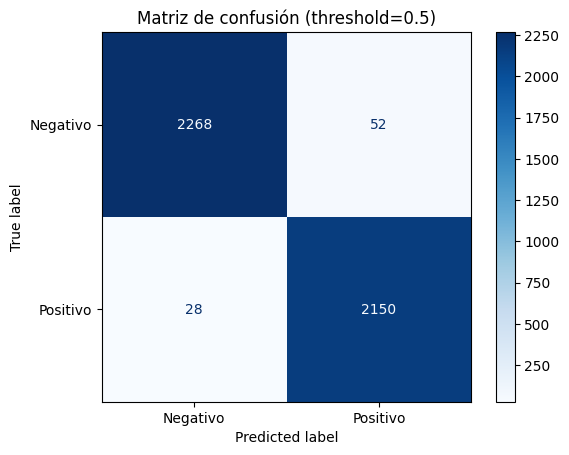

TN=2268 FP=52 FN=28 TP=2150
Accuracy=0.9822  Precision=0.9764  Recall=0.9871  F1=0.9817  ROC-AUC=0.9979

Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.99      0.98      0.98      2320
    Positivo       0.98      0.99      0.98      2178

    accuracy                           0.98      4498
   macro avg       0.98      0.98      0.98      4498
weighted avg       0.98      0.98      0.98      4498



In [52]:
# MATRIZ DE CONFUSION
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo","Positivo"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Matriz de confusión (threshold={threshold})")
plt.show()

# METRICAS
tn, fp, fn, tp = cm.ravel()
acc = (tp + tn) / cm.sum()
precision = tp / (tp + fp) if (tp+fp) else 0.0
recall = tp / (tp + fn) if (tp+fn) else 0.0
f1 = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0
auc = roc_auc_score(y_true, y_pred_prob)

print(f"TN={tn} FP={fp} FN={fn} TP={tp}")
print(f"Accuracy={acc:.4f}  Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  ROC-AUC={auc:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=['Negativo','Positivo']))

##**Predicciones de texto nuevo**

PARRAFOS

In [53]:
texts = tf.constant([
    "Former NASA scientist Dr. Leonard Carmichael announced on Thursday that a hidden city has been discovered beneath the surface of Antarctica using satellite radar imaging. According to preliminary reports, the structures resemble ancient pyramids aligned with celestial constellations, leading some researchers to believe that the ruins could predate all known human civilizations. The discovery, allegedly made by a joint U.S.-European research mission, has been kept secret by world governments due to “potential geopolitical consequences.” Dr. Carmichael claimed that the team uncovered symmetrical walls, tunnels, and chambers nearly two miles below the ice sheet, suggesting that the area was once free of ice thousands of years ago. “This changes everything we know about human history,” he said during a private scientific symposium in Geneva. Several conspiracy theorists quickly linked the finding to theories of advanced prehistoric societies and alien intervention. NASA and the European Space Agency, however, have declined to comment publicly, fueling even more speculation. Social media users have circulated supposed leaked images of the subterranean site, showing geometric patterns and metallic structures. Critics argue that the photos are digitally manipulated and that the radar data was misinterpreted. Still, many online forums insist that an official announcement will come “within the year,” revealing the existence of an advanced ancient civilization under Antarctica’s ice."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
[0.00144197] [0]


In [54]:
texts = tf.constant([
    "The European Space Agency (ESA) announced on Tuesday that its Gaia space observatory has mapped over 1.8 billion stars in the Milky Way, creating the most detailed 3D chart of our galaxy ever produced. Launched in 2013, Gaia’s mission is to precisely measure the position, distance, and motion of stars, providing astronomers with an unprecedented view of the Milky Way’s structure and evolution. The new dataset, released in 2024, includes not only stars but also information about asteroids, quasars, and distant galaxies. “This is the most complete map of our cosmic neighborhood,” said Timo Prusti, Gaia’s project scientist. Researchers are using the data to track how the Milky Way has changed over billions of years and to study how stars migrate through space. The catalog also contains details on the chemical composition of stars, helping scientists understand how heavy elements were formed in earlier generations of stellar evolution. The ESA expects Gaia’s findings to benefit several branches of astronomy, from exoplanet detection to dark matter research. With each new data release, the observatory continues to refine our understanding of the universe, confirming its status as one of the most ambitious and successful missions in modern astrophysics."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
[0.10323448] [0]


ORACIONES

FALSA

In [55]:
texts = tf.constant([
    "Scientists from the International Space Research Agency have announced that the Moon will turn completely green next month due to a rare combination of cosmic radiation and atmospheric particles. Experts recommend taking pictures, as this event supposedly happens only once every 500 years."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
[0.9736554] [1]


REAL

In [56]:
texts = tf.constant([
    "NASA’s James Webb Space Telescope captured detailed images of a distant galaxy, NGC 346, revealing new insights into star formation. The data, released in 2024, show young stars surrounded by clouds of gas and dust, helping scientists understand how galaxies evolve over time."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[0.00334446] [0]


FALSA DIFICIL

In [57]:
texts = tf.constant([
    "A new study claims that drinking two cups of coffee before bed can improve sleep quality and memory retention. Researchers allegedly found that caffeine helps the brain relax and promotes deeper rest phases during the night."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
[0.94404936] [1]


REAL AMBIGUA

In [58]:
texts = tf.constant([
    "Researchers from Stanford University reported a potential link between smartphone usage at night and increased anxiety levels among young adults. Although the findings are not yet peer-reviewed, the study suggests that screen exposure before sleep might influence emotional regulation."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[0.51597387] [1]


In [59]:
texts = tf.constant([
    "The International Energy Agency (IEA) reported on Wednesday that global renewable energy capacity grew by a record 510 gigawatts in 2024, marking the fastest expansion in history. According to the agency’s annual review, solar and wind power accounted for nearly 90% of new installations, driven largely by investments in China, the United States, and the European Union. The IEA noted that renewable sources now represent about 42% of total global electricity generation. Executive Director Fatih Birol emphasized that the growth shows the world is “moving decisively toward a cleaner and more secure energy future,” although he cautioned that more policy efforts are needed to meet the Paris Agreement climate goals. The report also highlighted that battery storage capacity doubled in 2024, reflecting rapid innovation in grid technology and energy efficiency."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
[0.98689973] [1]


REAL

In [61]:
texts = tf.constant([
    "The United States Federal Reserve decided on Thursday to keep interest rates steady for the third consecutive quarter, signaling growing confidence that inflation is under control. In a statement, Chair Jerome Powell said that the decision reflects “steady progress toward the 2% inflation target” while maintaining economic stability. The central bank’s report showed inflation slowing to 2.3% year over year, with unemployment remaining below 4%. Economists expect a potential rate cut in early 2025 if the current trend continues. Markets reacted positively to the announcement, with the S&P 500 closing up 1.4% and Treasury yields slightly declining."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
[0.9936169] [1]


FALSA

In [62]:
texts = tf.constant([
    "A new study from Harvard University claims that drinking five cups of coffee a day can completely reverse aging. Researchers allegedly found that caffeine repairs DNA damage and restores youthful energy levels, suggesting coffee could soon replace traditional anti-aging treatments."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
[0.09878978] [0]


In [63]:
texts = tf.constant([
    "The U.S. government announced a plan to replace all human teachers in public schools with advanced AI robots starting next year. Officials claim that the new system will improve education quality and reduce costs, but critics warn it could lead to massive unemployment among educators."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
[0.00116423] [0]


real

In [66]:
texts = tf.constant([
    "A new report from the United Nations shows that global carbon emissions rose slightly in 2024, despite international efforts to promote renewable energy and reduce fossil fuel use."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
[0.8781227] [1]


In [68]:
texts = tf.constant([
    "NASA confirmed that its Perseverance rover has successfully collected another rock sample on Mars, which will be stored for a future return mission to Earth."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
[0.02965531] [0]


FALSA

In [69]:
texts = tf.constant([
    "Google announced it has developed a chip that can directly translate human thoughts into text messages without using a phone or computer. The company says the device will be available next year."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
[0.03184103] [0]


Real

In [71]:
texts = tf.constant([
    "Scientists reported that 2024 was one of the hottest years on record, with global temperatures rising by 1.4°C compared to pre-industrial levels."
])
X = encoder(texts)
probs = model.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
[0.9404282] [1]
